# Demo 1

Once we have our Python environment installed, we can start the lab. The data we will be using is a **Landsat 8** image over Florence, OR acquired in July 2021. It can be downloaded from [here](https://prodduke-my.sharepoint.com/:f:/g/personal/jr555_duke_edu/EsDaqtUv1WlIsaa4PXjBo4gBrPL-3O8ABOKau7MN4vZS3w?e=WnJ79n). Note that there are **multiple files** that correspond to different **bands** which represent the reflectance in a **specific wavelength** (e.g. red, green, or blue). Below are the band designations for Landsat 8. 

```{image} images/landsat_bands.jpg
:alt: landsat 8 bands
:class: bg-primary mb-1
:width: 600px
:align: center
```

The important thing to know about Python is that specialized tools are provided by packages that have to be imported.

One of the most commonly used packages is called `NumPy`, which stands for **Numerical Python**. `NumPy` contains many useful functions for working with large, multi-dimensional arrays such as gridded satellite imagery. We can access the functions provided by `NumPy` using the `import` statement and module name (e.g. `import numpy`). However, it is standard procedure to shorten the imported name to `np` for better code readability. This is a widely adopted convention that we should follow so that anyone working with our code can easily understand it.

In [1]:
import numpy as np

Another useful package is `rasterio` which contains functions for reading and writing raster datasets that are formatted as `GeoTIFF` or similar.

In [2]:
import rasterio

We can make a variable containing all the Landsat 8 files using the [`glob`](https://docs.python.org/3/library/glob.html) package which finds all the pathnames matching a specified pattern according to the rules used by the Unix shell. For example, `*.tif` returns all files in the `data/landsat/` folder that have the `.tif` file type.

In [3]:
# Define list of Landsat bands
import glob
files = sorted(glob.glob('data/landsat/*.tif'))
files

['data/landsat/band1.tif',
 'data/landsat/band2.tif',
 'data/landsat/band3.tif',
 'data/landsat/band4.tif',
 'data/landsat/band5.tif',
 'data/landsat/band6.tif',
 'data/landsat/band7.tif']

## Open dataset

We can open one of these bands using the `rasterio` function, `open()`. This function takes a **path string** and returns a **dataset object**.

In [4]:
# Open a single band
src = rasterio.open(files[0])

````{margin}
```{note}
`src` stands for **source**
```
````

## Dataset attributes

The **dataset object** contains a number of **attributes** which can be explored using the following methods. Remember that a raster **band** is an array of values representing **a single** variable in 2D space. All bands of a dataset have the **same** number of rows and columns.

In [5]:
print(f"Number of bands: {src.count}")
print(f"Width: {src.width}")
print(f"Height: {src.height}")

Number of bands: 1
Width: 1208
Height: 1422


## Georeferencing

Each pixel in our raster dataset can be mapped to regions on the Earth's surface. We can display the **coordinate reference system** of our data using the `crs` method. 

In [6]:
src.crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32610"]]')

This is a lot of information but the important thing to know is the first line that says our `PROJCS` (which stands for **Projected CRS**) is `WGS 84 / UTM zone 10N` which is fairly standard way of projecting data in meters. 

Finally, we can display the  dataset's geospatial transform using the `transform` method. This function displays the **spatial resolution** of the dataset (i.e. the dimensions that each pixel of our dataset represents on the ground). Since our dataset has a **UTM projection** (i.e. `EPSG:32610`), the units of spatial resolution are in **meters**. 

In [7]:
src.transform

Affine(30.0, 0.0, 391695.0,
       0.0, -30.0, 4880565.0)

## Reading raster data

Now that we have some basic information about our data, we can go ahead and import it using the `read()` function. Data from a raster band can be accessed by the band's index number. Note that bands are indexed from 1 due to a  GDAL convention. 

In [8]:
band_1 = src.read(1)

The `read()` method returns a numpy N-D array.

In [9]:
band_1

array([[   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ..., 7350, 7394, 7301],
       [   0,    0,    0, ..., 7381, 7427, 7289],
       [   0,    0,    0, ..., 7435, 7322, 7382]],
      shape=(1422, 1208), dtype=uint16)

In [10]:
type(band_1)

numpy.ndarray

We can plot a figure showing our data using the `matplotlib` package.

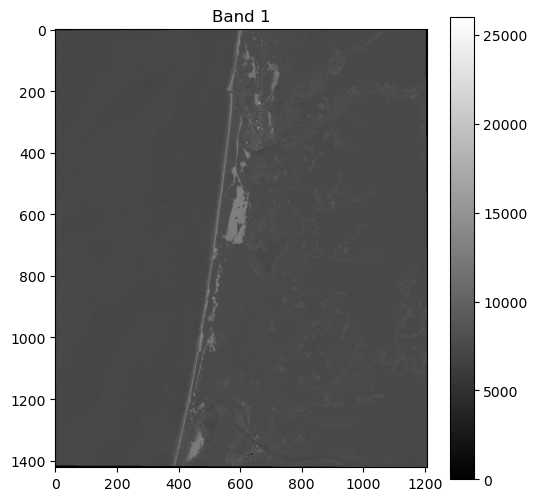

In [11]:
# Plot dataset
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(band_1, cmap='gray')
ax.set_title("Band 1")
fig.colorbar(im, orientation='vertical')
plt.show()

## Band indices 

As we have talked about in class, we compute indices to emphasize different land cover types. A commonly used index is the **Normalized Difference Vegetation Index (NDVI)** which emphasizes live, green vegetation. NDVI is computed using the **red** and **near-infrared** bands which, in the case of Landsat 8, correspond to bands 4 and 5, respectively.

> NDVI = (Band 5 - Band 4) / (Band 5 + Band 4)

So let's go ahead and read these two bands.

```{caution}
Remember that Python uses zero indexing, so the first band (i.e. 0) corresponds to band 1.
```

In [12]:
src_4 = rasterio.open(files[3])
band_4 = src_4.read(1)

src_5 = rasterio.open(files[4])
band_5 = src_5.read(1)

We can now subtract and divide the bands to produce the NDVI. 

```{caution}
Note that we have to make sure our bands are converted to `float` datatypes before dividing.
```

In [13]:
np.seterr(divide='ignore', invalid='ignore')
ndvi = (band_5.astype(float) - band_4.astype(float)) / (band_5.astype(float) + band_4.astype(float))

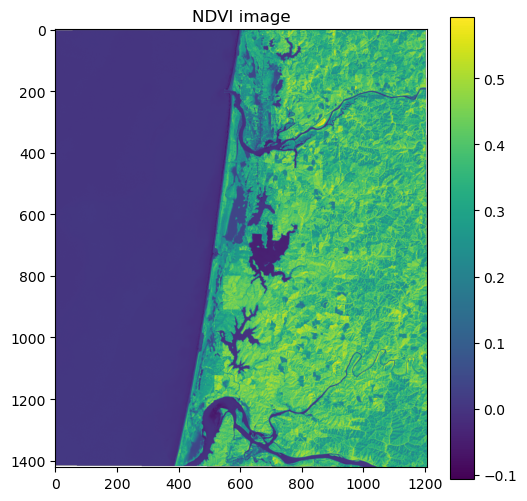

In [14]:
# Plot dataset
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(ndvi, cmap='viridis')
ax.set_title("NDVI image")
fig.colorbar(im, orientation='vertical')
plt.show()

In the figure, the high pixel values of healthy green forests make it distinguishable from other land cover types such as sand dunes and water.

Another popular index is the **Normalized Difference Water Index (NDWI)** which emphasizes pixels that contain water. The NDWI is computed using the **green** and **near-infrared** bands which, in the case of Landsat 8, correspond to bands 3 and 5, respectively.

> NDWI = (Band 3 - Band 5) / (Band 3 + Band 5)

In [15]:
src_3 = rasterio.open(files[2])
band_3 = src_3.read(1)

ndwi = (band_3.astype(float) - band_5.astype(float)) / (band_3.astype(float) + band_5.astype(float))

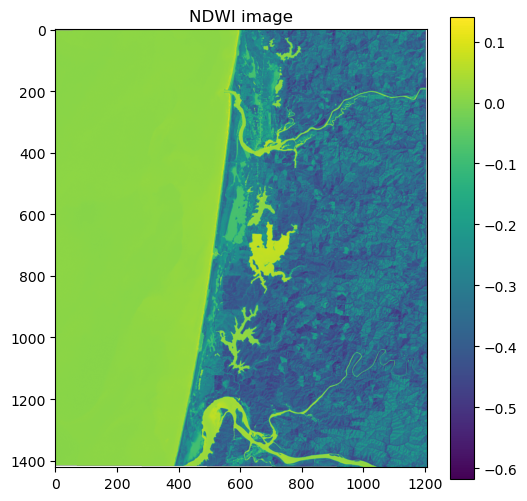

In [16]:
# Plot dataset
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(ndwi, cmap='viridis')
ax.set_title("NDWI image")
fig.colorbar(im, orientation='vertical')
plt.show()

In this figure, the positive pixel values of water make it easily distinguishable from other land cover types such as sand dunes and forests.

## True color Landsat image

When making figures for presentations, we often want a "true color" background which combines the red, green, and blue bands to make an image similar to what the human eye would observe. 

We can actually pass a 3-band array to [`.imshow`](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.imshow.html) and plot it as an RGB image because it is such a common image format. First, we will read the blue band and stack it with the red and green bands.

In [17]:
src_2 = rasterio.open(files[1])
band_2 = src_2.read(1)

In [18]:
# Produce a new array by stacking the RGB bands
rgb = np.dstack((band_4, band_3, band_2))

We know the the datatype of the image is `uint16`, which stands for unsigned 16-bit integer.

In [19]:
src_2.profile['dtype']

'uint16'

But `.imshow` requires our data to have a range of 0-255 or 0-1. We can scale the pixel values by dividing by the maximum `uint16` value (i.e. 2^16) and multiplying by our desired max value (i.e. 2^8). We also have to convert the variable to an `uint8` data type.

In [20]:
# Scale data
rgb_255 = np.uint8((rgb / 65536) * 255)
rgb_255.dtype

dtype('uint8')

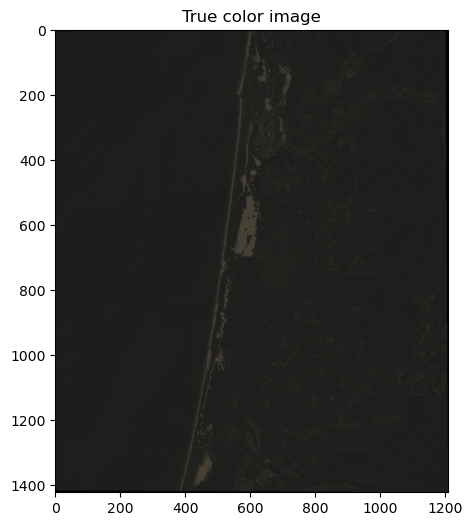

In [21]:
# Plot as RGB image
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(rgb_255)
ax.set_title("True color image")
plt.show()

This looks great but is pretty dark because the range of pixel values is much less than 255 so there it is difficult to differentiate colors. 

In [22]:
rgb_255.min(), rgb_255.max()

(np.uint8(0), np.uint8(123))

One way of dealing with this is to **stretch** the image using a **percentile clip**. This technique redistributes all pixel values between 0 and 255. In our case, all values of 0 will remain at 0, values of 123 will become 255, and the rest of the values will be spread proportionally in between. 

In [23]:
def percentile_stretch(array, pct = [2, 98]):
    
    array_min, array_max = np.nanpercentile(array,pct[0]), np.nanpercentile(array,pct[1])
    stretch = (array - array_min) / (array_max - array_min)
    
    stretch[stretch > 1] = 1
    stretch[stretch < 0] = 0
    
    return stretch

# Call function
array = percentile_stretch(rgb_255)

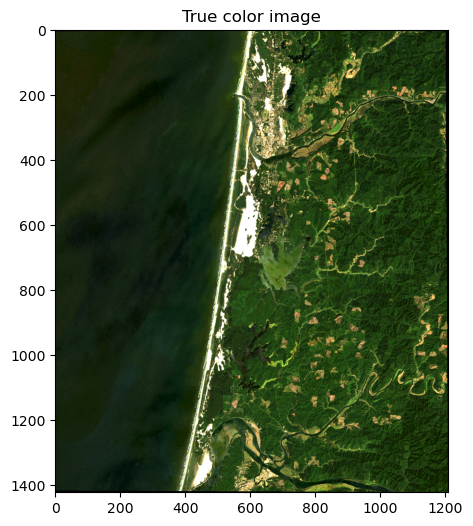

In [24]:
# Plot as RGB image
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(array)
ax.set_title("True color image")
plt.show()

This looks much nicer.

## Write file

We can write these data to a new file using the following command. 

In [25]:
#Test write file
with rasterio.open(
        "data/ndwi.tif",
        mode="w",
        driver="GTiff",
        height=ndwi.shape[0],
        width=ndwi.shape[1],
        count=1,
        dtype=ndwi.dtype,
        crs=src.crs,
        transform=src.transform,
) as new_dataset:
        new_dataset.write(ndwi, 1)

This is useful because we can open the `ndwi.tif` in QGIS to visualize what we have produced.